In [ ]:
%matplotlib inline



# Sleep stage classification from polysomnography (PSG) data

<div class="alert alert-info"><h4>Note</h4><p>This code is taken from the analysis code used in
          :footcite:`ChambonEtAl2018`. If you reuse this code please consider
          citing this work.</p></div>

This tutorial explains how to perform a toy polysomnography analysis that
answers the following question:

.. important:: Given two subjects from the Sleep Physionet dataset
               :footcite:`KempEtAl2000,GoldbergerEtAl2000`, namely
               *Alice* and *Bob*, how well can we predict the sleep stages of
               *Bob* from *Alice's* data?

This problem is tackled as supervised multiclass classification task. The aim
is to predict the sleep stage from 5 possible stages for each chunk of 30
seconds of data.



In [ ]:
# Authors: Alexandre Gramfort <alexandre.gramfort@inria.fr>
#          Stanislas Chambon <stan.chambon@gmail.com>
#          Joan Massich <mailsik@gmail.com>
#
# License: BSD-3-Clause

In [ ]:
!pip install mne

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.datasets.sleep_physionet.age import fetch_data
from mne.time_frequency import psd_welch

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

## Load the data

Here we download the data from two subjects and the end goal is to obtain
:term:`epochs` and its associated ground truth.

MNE-Python provides us with
:func:`mne.datasets.sleep_physionet.age.fetch_data` to conveniently download
data from the Sleep Physionet dataset
:footcite:`KempEtAl2000,GoldbergerEtAl2000`.
Given a list of subjects and records, the fetcher downloads the data and
provides us for each subject, a pair of files:

* ``-PSG.edf`` containing the polysomnography. The :term:`raw` data from the
  EEG helmet,
* ``-Hypnogram.edf`` containing the :term:`annotations` recorded by an
  expert.

Combining these two in a :class:`mne.io.Raw` object then we can extract
:term:`events` based on the descriptions of the annotations to obtain the
:term:`epochs`.

### Read the PSG data and Hypnograms to create a raw object



In [ ]:
ALICE, BOB = 0, 1

[alice_files, bob_files] = fetch_data(subjects=[ALICE, BOB], recording=[1])

raw_train = mne.io.read_raw_edf(alice_files[0], stim_channel='marker',
                                misc=['rectal'])
annot_train = mne.read_annotations(alice_files[1])

raw_train.set_annotations(annot_train, emit_warning=False)

# plot some data
# scalings were chosen manually to allow for simultaneous visualization of
# different channel types in this specific dataset
raw_train.plot(start=60, duration=60,
               scalings=dict(eeg=1e-4, resp=1e3, eog=1e-4, emg=1e-7,
                             misc=1e-1))

In [ ]:
subj1, subj2 = fetch_data(subjects=[0, 1], recording=[1])
raw_train = mne.io.read_raw_edf(subj1[0], stim_channel='marker', misc=['rectal'])
raw_train.get_channel_types()

In [ ]:
dat = raw_train.get_data()

In [ ]:
print(f"Number of datapoints in a single channel = {raw_train.get_data().shape[1]}, number of channels = {raw_train.get_data().shape[0]}")

In [ ]:
CHANNEL_NAMES = raw_train.ch_names


In [ ]:
eeg1 = raw_train.get_data()[0]
t = np.linspace(0, len(eeg1) / 100, len(eeg1))  # time array in hours
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(t, eeg1)
# ax.plot(t[60*100:60*100*2], eeg1[60*100:60*100*2])


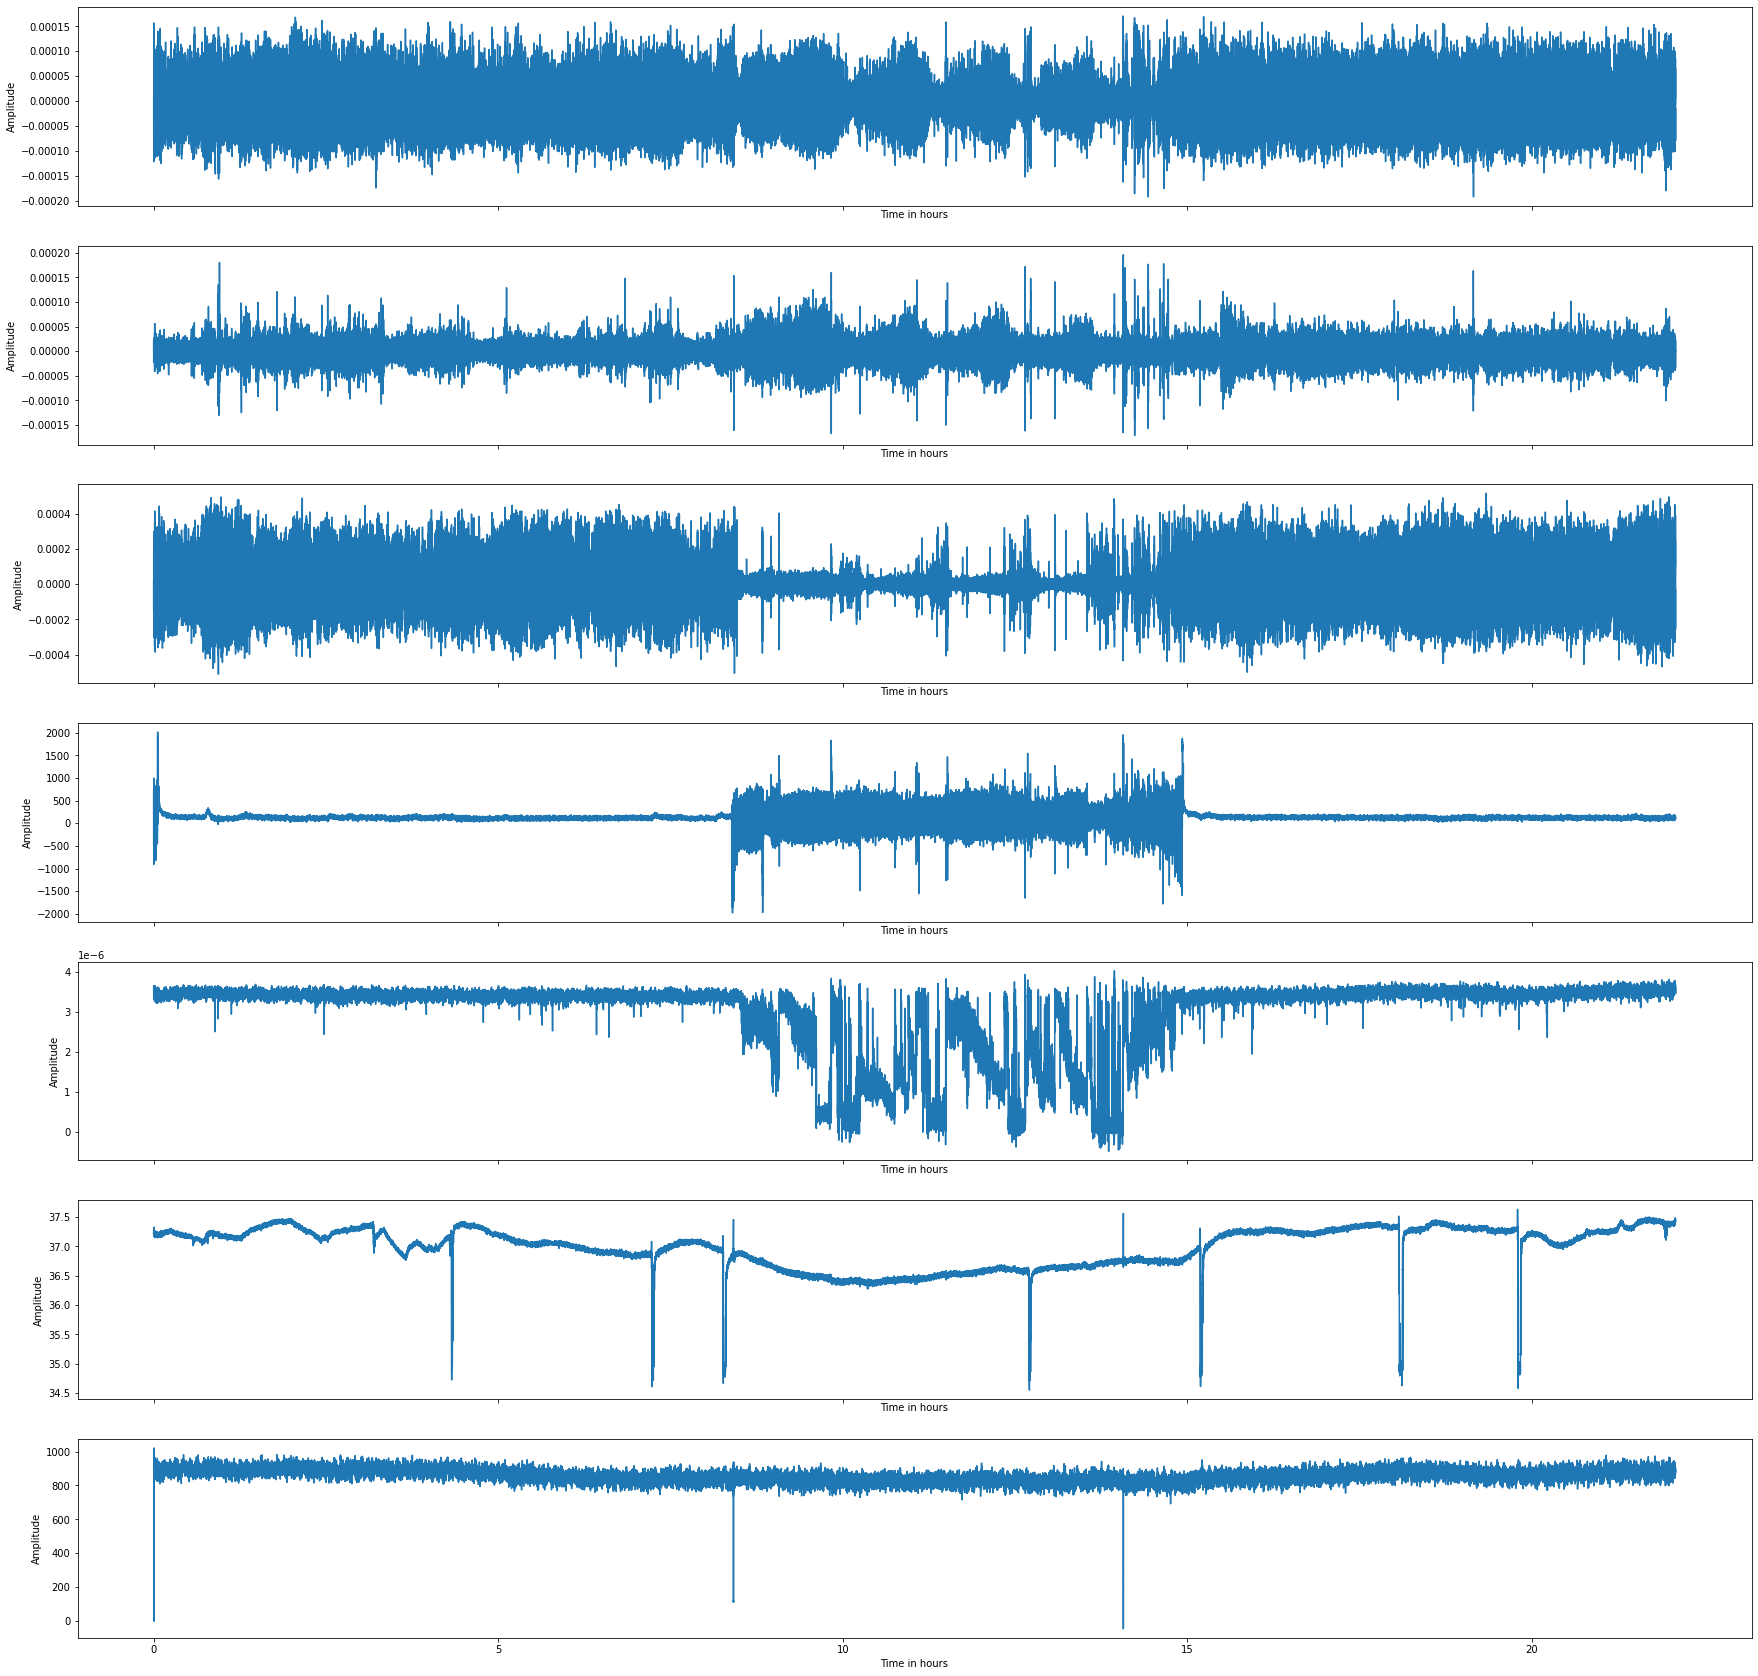

In [ ]:
fig_7, ax_7 = plt.subplots(7, 1, sharex=True, figsize=(30, 30))
for i in range(7):
    ax_7[i].plot(t/3600, raw_train.get_data()[i])
    ax_7[i].set_ylabel("Amplitude")
    ax_7[i].set_xlabel("Time in hours")

fig.suptitle("7 channel eeg signal, sampled at 100 Hz")
plt.show()

Using default location ~/mne_data for PHYSIONET_SLEEP...
Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


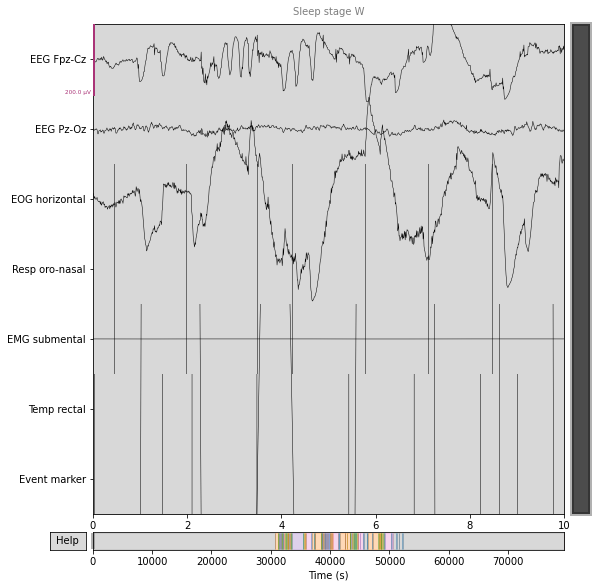

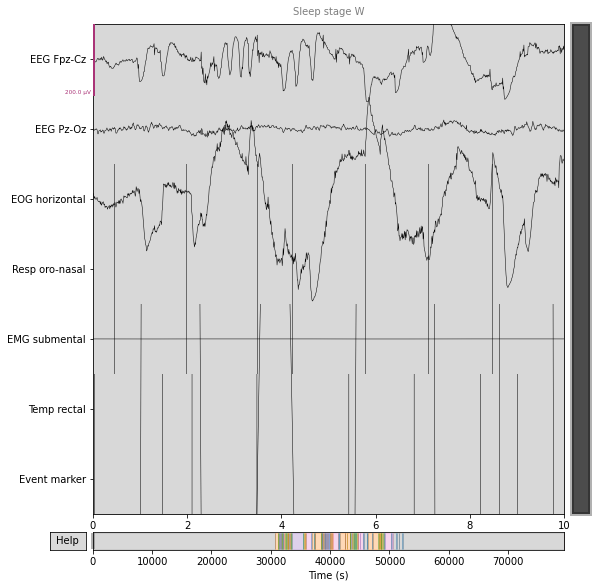

In [ ]:
ALICE, BOB = 0, 1

[alice_files, bob_files] = fetch_data(subjects=[ALICE, BOB], recording=[1])

raw_train = mne.io.read_raw_edf(alice_files[0], stim_channel='marker',
                                misc=['rectal'])
annot_train = mne.read_annotations(alice_files[1])

raw_train.set_annotations(annot_train, emit_warning=False)

# plot some data
# scalings were chosen manually to allow for simultaneous visualization of
# different channel types in this specific dataset
raw_train.plot(
               scalings=dict(eeg=1e-4, resp=1e3, eog=1e-4, emg=1e-7,
                             misc=1e-1))

In [ ]:
np.unique(annot_train.description)

array(['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4',
       'Sleep stage ?', 'Sleep stage R', 'Sleep stage W'], dtype='<U13')

In [ ]:
def average_stage_duration(annots, stage: str):
    """
    Function for calculating average duration of stage
    """
    durations = [i['duration'] for i in annots if i['description'] == stage]
    return np.mean(durations)

In [ ]:
def average_stage_amplitude(signal, annots, stage: str):
    """
    Function for calculating the average amplitude of stage
    """
    

In [ ]:
average_stage_duration(annot_train, stage='Sleep stage 2')

187.5

In [ ]:
from scipy.stats import mode 
mode([i['duration'] for i in annot_train]).mode[0]

30.0

In [ ]:
# def plot_stage_eegs(signal, annots):
#     categories = np.unique(annots.description)
#     mode_ = mode([i['duration'] for i in annot_train]).mode[0]
#     fig, ax = plt.subplots(len(annots), 1, figsize=(20, 15))
#     for i in range(len(categories)):
        

SyntaxError: ignored

In [ ]:
signal = raw_train.get_data()[0]
t = np.linspace(0, len(signal) / 100, len(signal))  
idxs_different = {}
for idx, val in enumerate(annot_train.description):
    if val not in idxs_different:
        idxs_different[val] = idx


In [ ]:
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

In [ ]:
key_values = [tup for tup in idxs_different.items()]
key_values

[('Sleep stage W', 0),
 ('Sleep stage 1', 1),
 ('Sleep stage 2', 2),
 ('Sleep stage 3', 3),
 ('Sleep stage 4', 6),
 ('Sleep stage R', 44),
 ('Sleep stage ?', 153)]

In [ ]:
from scipy.fft import rfft, rfftfreq

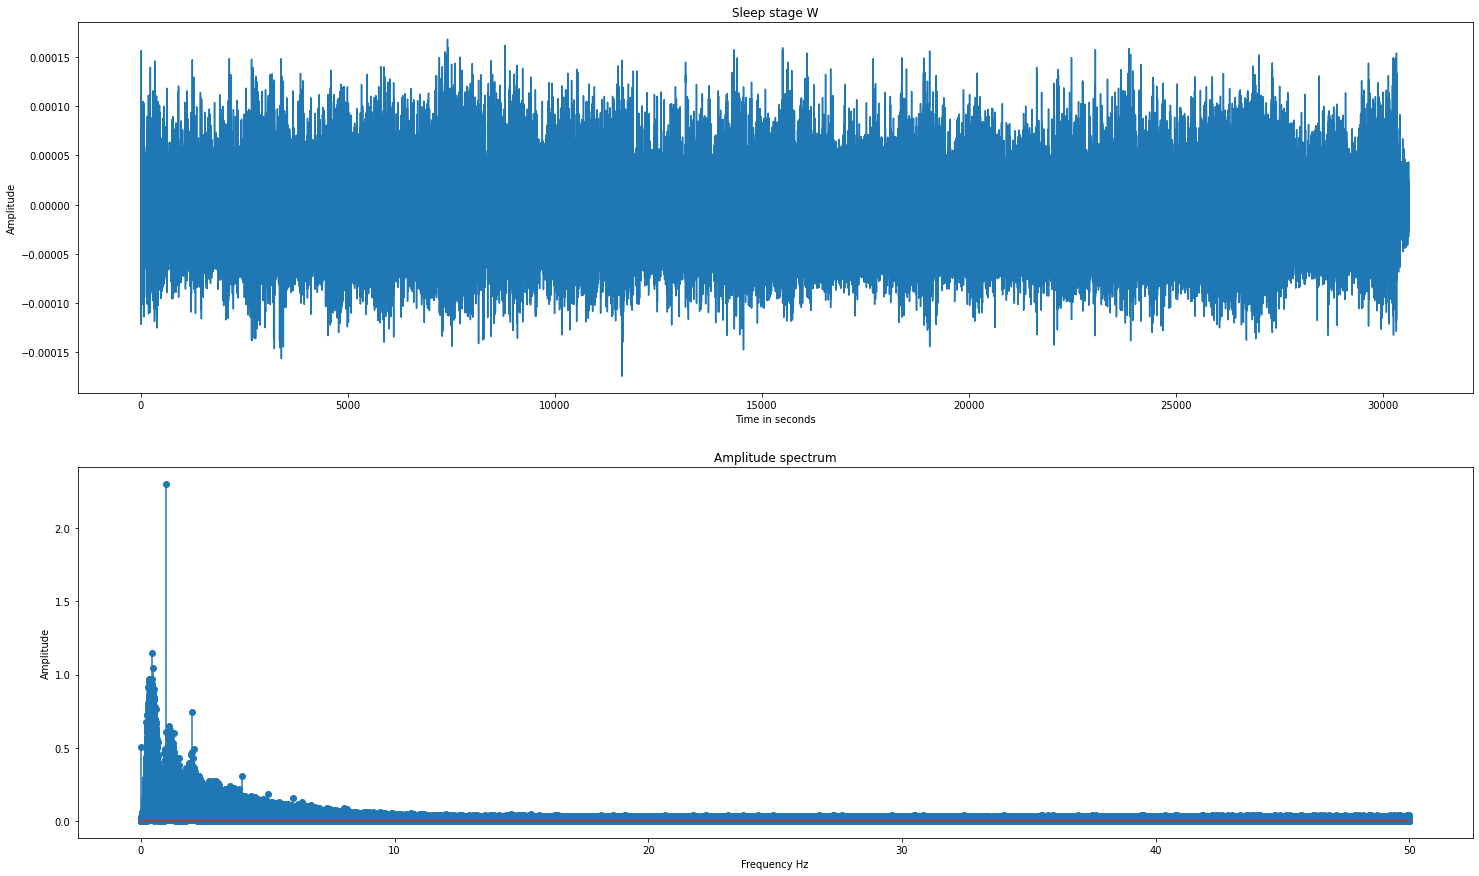

In [ ]:
key, idx = key_values[0]
t_1 = int(annot_train[idx]['onset'])*100
t_2 = int(100*annot_train[idx]['duration']) + t_1

fig, ax = plt.subplots(2, 1, figsize=(25, 15))
ax[0].plot(t[t_1:t_2], signal[t_1:t_2])
ax[0].set_title(key)
ax[0].set_xlabel("Time in seconds")
ax[0].set_ylabel("Amplitude")

frr_wo = rfft(signal[t_1:t_2])
freq_wo = rfftfreq(n=len(signal[t_1:t_2]), d=1/100)
ax[1].stem(freq_wo, np.abs(frr_wo), use_line_collection=True)
ax[1].set_title('Amplitude spectrum')
ax[1].set_xlabel("Frequency Hz")
ax[1].set_ylabel("Amplitude")

plt.savefig('/content/stageW.png', dpi=300)
plt.show()

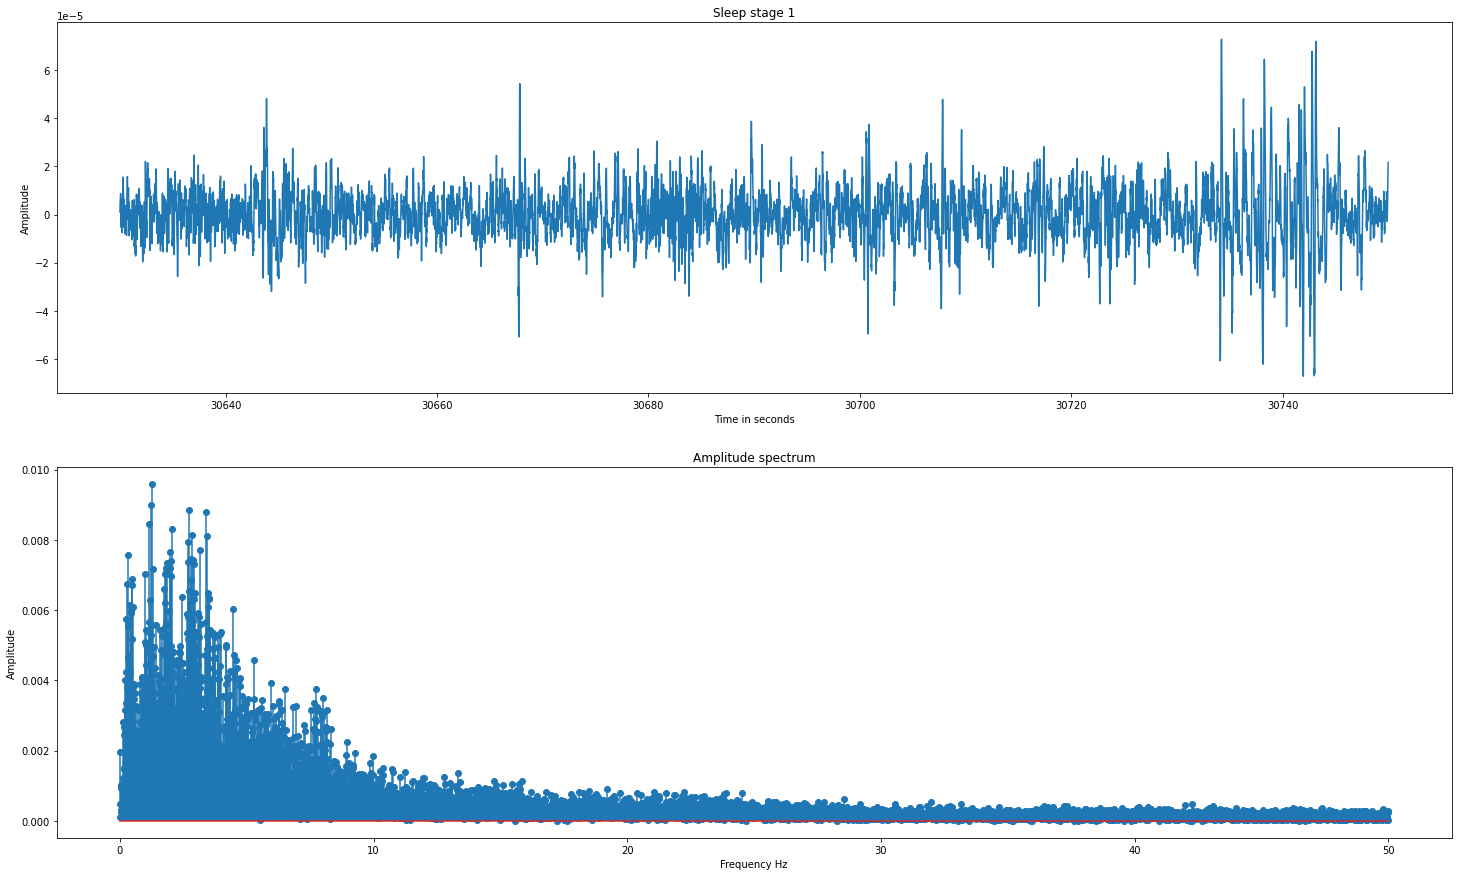

In [ ]:
key, idx = key_values[1]
t_1 = int(annot_train[idx]['onset'])*100
t_2 = int(100*annot_train[idx]['duration']) + t_1

fig, ax = plt.subplots(2, 1, figsize=(25, 15))
ax[0].plot(t[t_1:t_2], signal[t_1:t_2])
ax[0].set_title(key)
ax[0].set_xlabel("Time in seconds")
ax[0].set_ylabel("Amplitude")

frr_wo = rfft(signal[t_1:t_2])
freq_wo = rfftfreq(n=len(signal[t_1:t_2]), d=1/100)
ax[1].stem(freq_wo, np.abs(frr_wo), use_line_collection=True)
ax[1].set_title('Amplitude spectrum')
ax[1].set_xlabel("Frequency Hz")
ax[1].set_ylabel("Amplitude")

plt.savefig('/content/stage1.png', dpi=300)
plt.show()

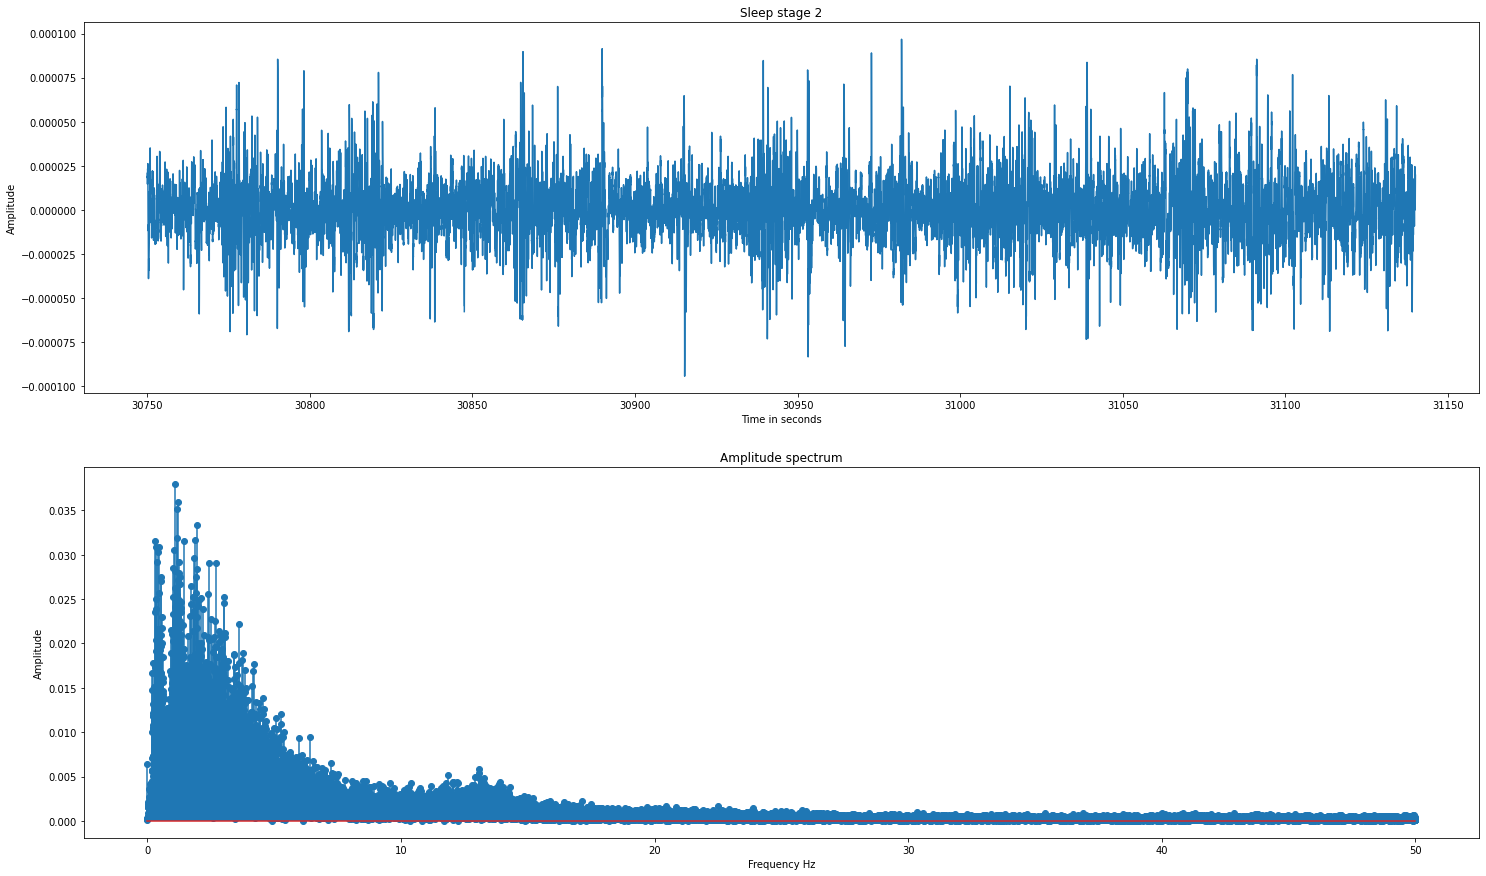

In [ ]:
key, idx = key_values[2]
t_1 = int(annot_train[idx]['onset'])*100
t_2 = int(100*annot_train[idx]['duration']) + t_1

fig, ax = plt.subplots(2, 1, figsize=(25, 15))
ax[0].plot(t[t_1:t_2], signal[t_1:t_2])
ax[0].set_title(key)
ax[0].set_xlabel("Time in seconds")
ax[0].set_ylabel("Amplitude")

frr_wo = rfft(signal[t_1:t_2])
freq_wo = rfftfreq(n=len(signal[t_1:t_2]), d=1/100)
ax[1].stem(freq_wo, np.abs(frr_wo), use_line_collection=True)
ax[1].set_title('Amplitude spectrum')
ax[1].set_xlabel("Frequency Hz")
ax[1].set_ylabel("Amplitude")

plt.savefig('/content/stage2.png', dpi=300)
plt.show()

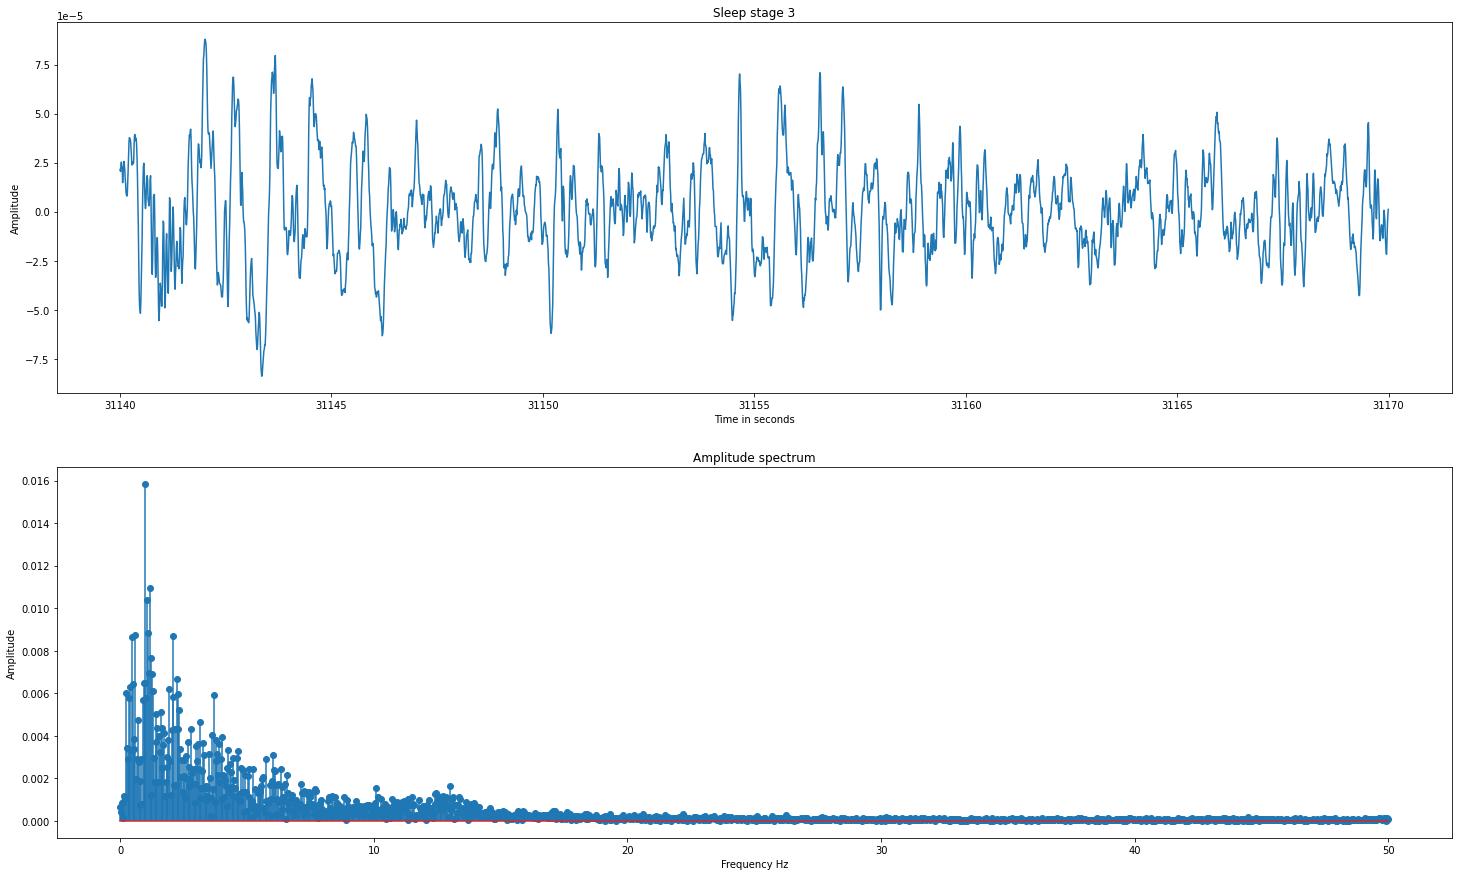

In [ ]:
key, idx = key_values[3]
t_1 = int(annot_train[idx]['onset'])*100
t_2 = int(100*annot_train[idx]['duration']) + t_1

fig, ax = plt.subplots(2, 1, figsize=(25, 15))
ax[0].plot(t[t_1:t_2], signal[t_1:t_2])
ax[0].set_title(key)
ax[0].set_xlabel("Time in seconds")
ax[0].set_ylabel("Amplitude")

frr_wo = rfft(signal[t_1:t_2])
freq_wo = rfftfreq(n=len(signal[t_1:t_2]), d=1/100)
ax[1].stem(freq_wo, np.abs(frr_wo), use_line_collection=True)
ax[1].set_title('Amplitude spectrum')
ax[1].set_xlabel("Frequency Hz")
ax[1].set_ylabel("Amplitude")

plt.savefig('/content/stage3.png', dpi=300)
plt.show()

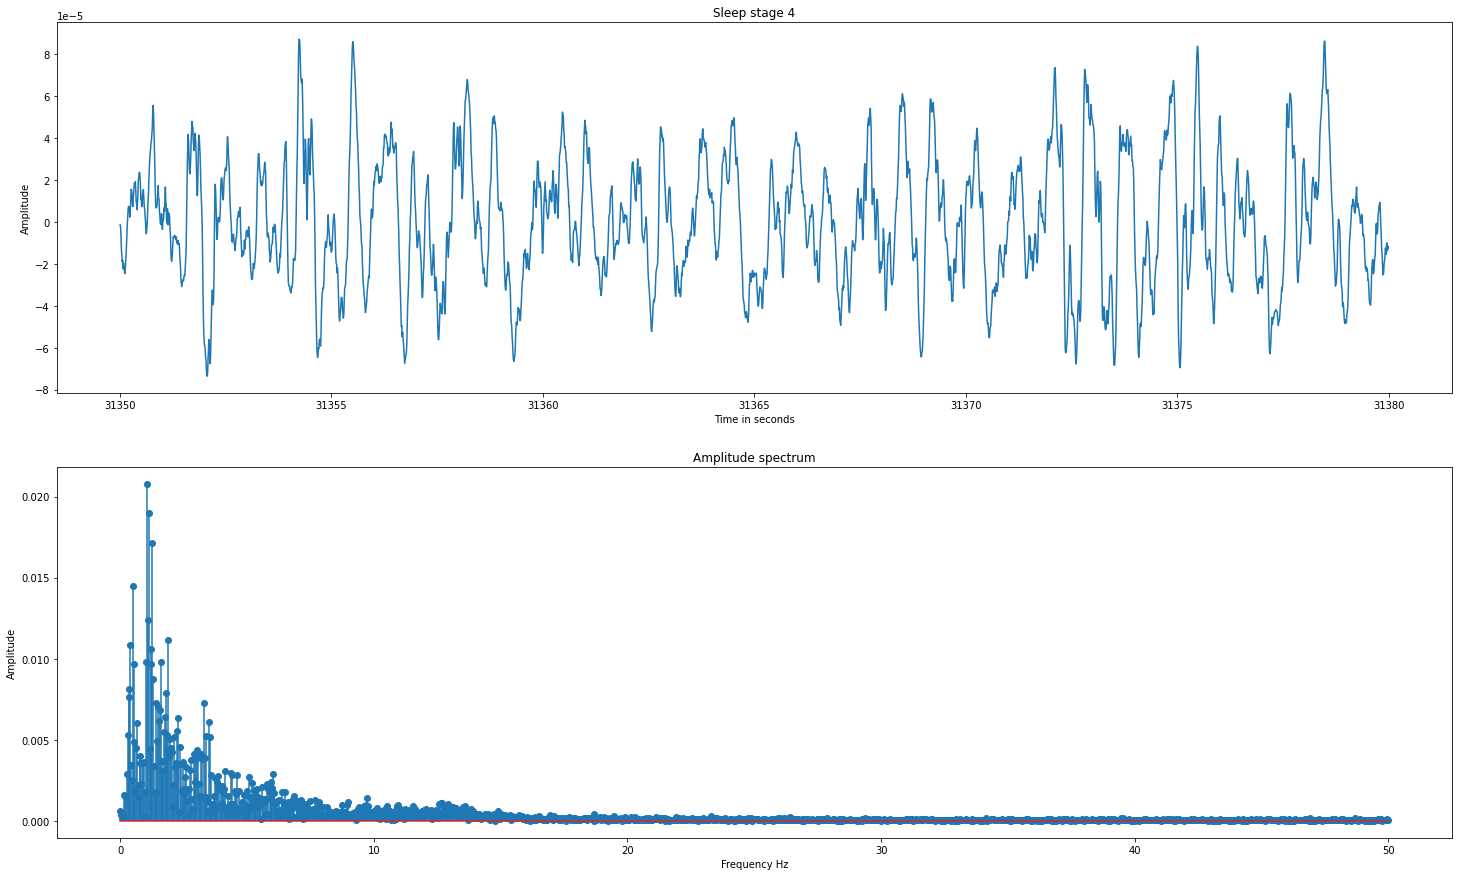

In [ ]:
key, idx = key_values[4]
t_1 = int(annot_train[idx]['onset'])*100
t_2 = int(100*annot_train[idx]['duration']) + t_1

fig, ax = plt.subplots(2, 1, figsize=(25, 15))
ax[0].plot(t[t_1:t_2], signal[t_1:t_2])
ax[0].set_title(key)
ax[0].set_xlabel("Time in seconds")
ax[0].set_ylabel("Amplitude")

frr_wo = rfft(signal[t_1:t_2])
freq_wo = rfftfreq(n=len(signal[t_1:t_2]), d=1/100)
ax[1].stem(freq_wo, np.abs(frr_wo), use_line_collection=True)
ax[1].set_title('Amplitude spectrum')
ax[1].set_xlabel("Frequency Hz")
ax[1].set_ylabel("Amplitude")

plt.savefig('/content/stage4.png', dpi=300)
plt.show()

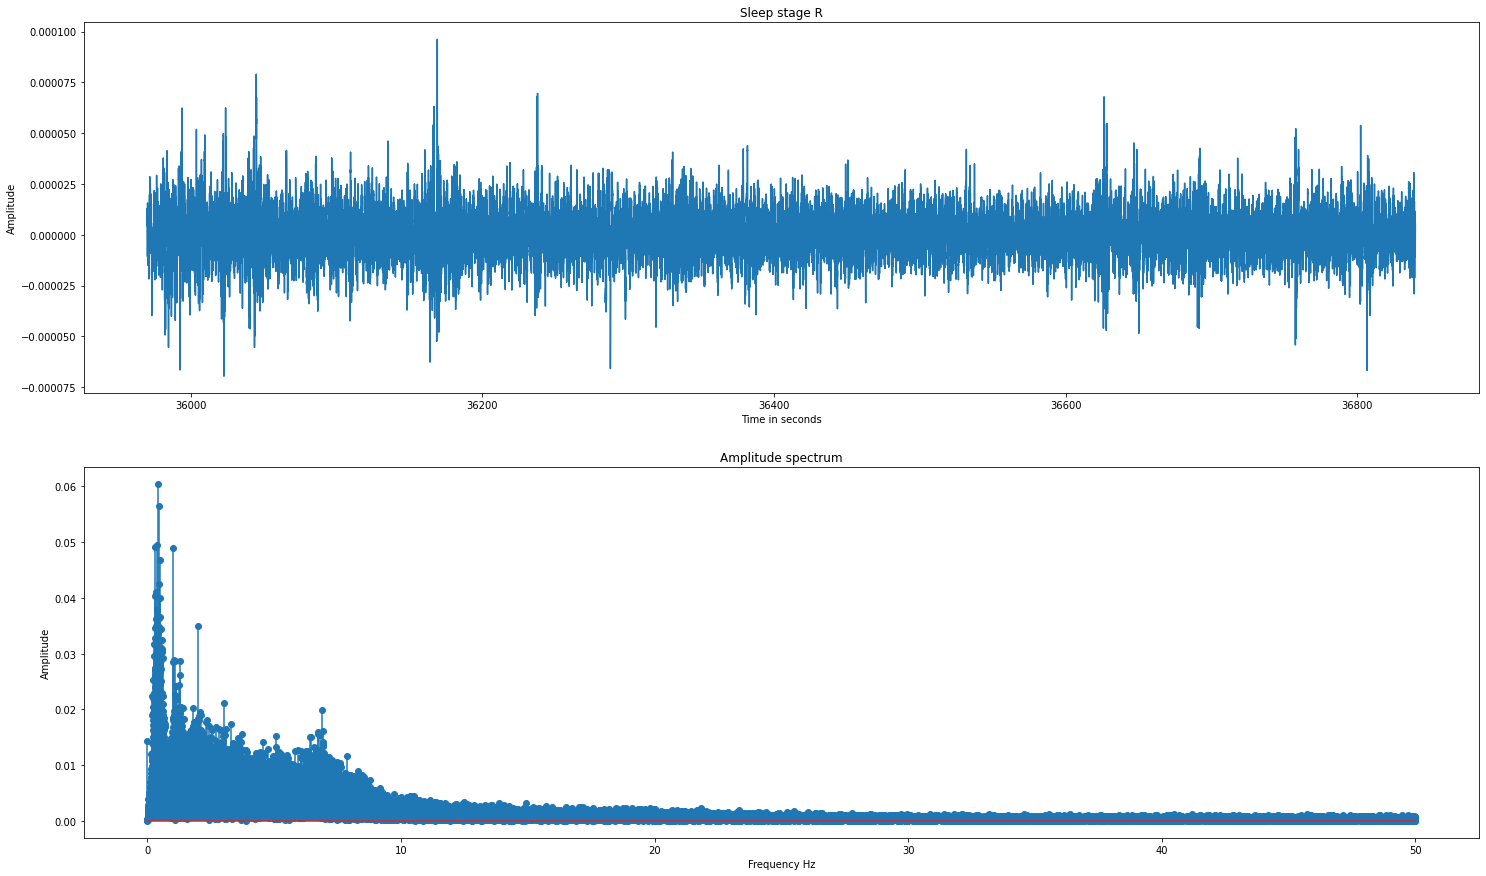

In [ ]:
key, idx = key_values[5]
t_1 = int(annot_train[idx]['onset'])*100
t_2 = int(100*annot_train[idx]['duration']) + t_1

fig, ax = plt.subplots(2, 1, figsize=(25, 15))
ax[0].plot(t[t_1:t_2], signal[t_1:t_2])
ax[0].set_title(key)
ax[0].set_xlabel("Time in seconds")
ax[0].set_ylabel("Amplitude")

frr_wo = rfft(signal[t_1:t_2])
freq_wo = rfftfreq(n=len(signal[t_1:t_2]), d=1/100)
ax[1].stem(freq_wo, np.abs(frr_wo), use_line_collection=True)
ax[1].set_title('Amplitude spectrum')
ax[1].set_xlabel("Frequency Hz")
ax[1].set_ylabel("Amplitude")

plt.savefig('/content/stageR.png', dpi=300)
plt.show()

In [ ]:
from scipy.signal import spectrogram

def func(signal, fs, t1, t2, f1, f2, noverlap=0):
    f, t, Sxx = spectrogram(signal, fs, noverlap=noverlap)

    # start_t_index = min(enumerate(t), key=lambda x: abs(x[1] - t1))[0]
    # stop_t_index = min(enumerate(t), key=lambda x: abs(x[1] - t2))[0]

    start_f_index = min(enumerate(f), key=lambda x: abs(x[1] - f1))[0]
    stop_f_index = min(enumerate(f), key=lambda x: abs(x[1] - f2))[0]

    start_t_index, stop_t_index = t1, t2
    assert start_t_index < stop_t_index
    assert start_f_index < stop_f_index
    plt.figure(figsize=(12, 6))
    plt.pcolormesh(t[start_t_index:stop_t_index], 
                   f[start_f_index: stop_f_index], 
                   Sxx[start_f_index: stop_f_index, start_t_index:stop_t_index], 
                   shading='gouraud')
    plt.xlabel("time in sec")
    plt.ylabel("Frequency")
    plt.show()
annot_train = mne.read_annotations(subj1[1])

dat = raw_train.get_data()[0]
idx_1, idx_2 = int(annot_train[1]['onset']), int(annot_train[-2]['onset'])
func(dat, fs=100, t1=idx_1, t2=idx_2, f1=0, f2=1)

In [ ]:
from scipy.signal import spectrogram
fig, axs = plt.subplots(figsize=(25, 5))
max_value = max(eeg1)

f, t, Sxx = spectrogram(eeg1, 100, noverlap=0)
freq_slice = np.where(f < 2)

f = f[freq_slice]
Sxx = Sxx[freq_slice,:][0]

axs.pcolormesh(t, f, Sxx, shading='gouraud', cmap="plasma")
axs
plt.show()


In [ ]:
plt.plot(eeg1)

In [ ]:
eeg1.shape
t.shape

In [ ]:
raw_train

In [ ]:
annot_train[-2]['onset'] - annot_train[1]['onset']

### Extract 30s events from annotations

The Sleep Physionet dataset is annotated using
`8 labels <physionet_labels_>`_:
Wake (W), Stage 1, Stage 2, Stage 3, Stage 4 corresponding to the range from
light sleep to deep sleep, REM sleep (R) where REM is the abbreviation for
Rapid Eye Movement sleep, movement (M), and Stage (?) for any none scored
segment.

We will work only with 5 stages: Wake (W), Stage 1, Stage 2, Stage 3/4, and
REM sleep (R). To do so, we use the ``event_id`` parameter in
:func:`mne.events_from_annotations` to select which events are we
interested in and we associate an event identifier to each of them.

Moreover, the recordings contain long awake (W) regions before and after each
night. To limit the impact of class imbalance, we trim each recording by only
keeping 30 minutes of wake time before the first occurrence and 30 minutes
after the last occurrence of sleep stages.



In [ ]:
annotation_desc_2_event_id = {'Sleep stage W': 1,
                              'Sleep stage 1': 2,
                              'Sleep stage 2': 3,
                              'Sleep stage 3': 4,
                              'Sleep stage 4': 4,
                              'Sleep stage R': 5}

# keep last 30-min wake events before sleep and first 30-min wake events after
# sleep and redefine annotations on raw data
annot_train.crop(annot_train[1]['onset'] - 30 * 60,
                 annot_train[-2]['onset'] + 30 * 60)
raw_train.set_annotations(annot_train, emit_warning=False)

events_train, _ = mne.events_from_annotations(
    raw_train, event_id=annotation_desc_2_event_id, chunk_duration=30.)

# create a new event_id that unifies stages 3 and 4
event_id = {'Sleep stage W': 1,
            'Sleep stage 1': 2,
            'Sleep stage 2': 3,
            'Sleep stage 3/4': 4,
            'Sleep stage R': 5}

# plot events
fig = mne.viz.plot_events(events_train, event_id=event_id,
                          sfreq=raw_train.info['sfreq'],
                          first_samp=events_train[0, 0])

# keep the color-code for further plotting
stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
a = mne.events_from_annotations(raw_train, event_id=annotation_desc_2_event_id, chunk_duration=30.)

In [ ]:
(events_train[0, 0]/100 - events_train[-1, 0]/100)/3600

In [ ]:
a[1]

In [ ]:
raw_train.info['sfreq']

### Create Epochs from the data based on the events found in the annotations



In [ ]:
tmax = 30. - 1. / raw_train.info['sfreq']  # tmax in included

epochs_train = mne.Epochs(raw=raw_train, events=events_train,
                          event_id=event_id, tmin=0., tmax=tmax, baseline=None)

print(epochs_train)

### Applying the same steps to the test data from Bob



In [ ]:
raw_test = mne.io.read_raw_edf(bob_files[0], stim_channel='marker',
                               misc=['rectal'])
annot_test = mne.read_annotations(bob_files[1])
annot_test.crop(annot_test[1]['onset'] - 30 * 60,
                annot_test[-2]['onset'] + 30 * 60)
raw_test.set_annotations(annot_test, emit_warning=False)
events_test, _ = mne.events_from_annotations(
    raw_test, event_id=annotation_desc_2_event_id, chunk_duration=30.)
epochs_test = mne.Epochs(raw=raw_test, events=events_test, event_id=event_id,
                         tmin=0., tmax=tmax, baseline=None)

print(epochs_test)

## Feature Engineering

Observing the power spectral density (PSD) plot of the :term:`epochs` grouped
by sleeping stage we can see that different sleep stages have different
signatures. These signatures remain similar between Alice and Bob's data.

The rest of this section we will create EEG features based on relative power
in specific frequency bands to capture this difference between the sleep
stages in our data.



In [ ]:
# visualize Alice vs. Bob PSD by sleep stage.
fig, (ax1, ax2) = plt.subplots(ncols=2)

# iterate over the subjects
stages = sorted(event_id.keys())
for ax, title, epochs in zip([ax1, ax2],
                             ['Alice', 'Bob'],
                             [epochs_train, epochs_test]):

    for stage, color in zip(stages, stage_colors):
        epochs[stage].plot_psd(area_mode=None, color=color, ax=ax,
                               fmin=0.1, fmax=20., show=False,
                               average=True, spatial_colors=False)
    ax.set(title=title, xlabel='Frequency (Hz)')
ax2.set(ylabel='µV^2/Hz (dB)')
ax2.legend(ax2.lines[2::3], stages)
plt.show()

### Design a scikit-learn transformer from a Python function

We will now create a function to extract EEG features based on relative power
in specific frequency bands to be able to predict sleep stages from EEG
signals.



In [ ]:
def eeg_power_band(epochs):
    """EEG relative power band feature extraction.

    This function takes an ``mne.Epochs`` object and creates EEG features based
    on relative power in specific frequency bands that are compatible with
    scikit-learn.

    Parameters
    ----------
    epochs : Epochs
        The data.

    Returns
    -------
    X : numpy array of shape [n_samples, 5]
        Transformed data.
    """
    # specific frequency bands
    FREQ_BANDS = {"delta": [0.5, 4.5],
                  "theta": [4.5, 8.5],
                  "alpha": [8.5, 11.5],
                  "sigma": [11.5, 15.5],
                  "beta": [15.5, 30]}

    psds, freqs = psd_welch(epochs, picks='eeg', fmin=0.5, fmax=30.)
    # Normalize the PSDs
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)

## Multiclass classification workflow using scikit-learn

To answer the question of how well can we predict the sleep stages of Bob
from Alice's data and avoid as much boilerplate code as possible, we will
take advantage of two key features of sckit-learn: `Pipeline`_ , and
`FunctionTransformer`_.

Scikit-learn pipeline composes an estimator as a sequence of transforms
and a final estimator, while the FunctionTransformer converts a python
function in an estimator compatible object. In this manner we can create
scikit-learn estimator that takes :class:`mne.Epochs` thanks to
``eeg_power_band`` function we just created.



In [ ]:
pipe = make_pipeline(FunctionTransformer(eeg_power_band, validate=False),
                     RandomForestClassifier(n_estimators=100, random_state=42))

# Train
y_train = epochs_train.events[:, 2]
pipe.fit(epochs_train, y_train)

# Test
y_pred = pipe.predict(epochs_test)

# Assess the results
y_test = epochs_test.events[:, 2]
acc = accuracy_score(y_test, y_pred)

print("Accuracy score: {}".format(acc))

In short, yes. We can predict Bob's sleeping stages based on Alice's data.

### Further analysis of the data

We can check the confusion matrix or the classification report.



In [ ]:
print(confusion_matrix(y_test, y_pred))

In [ ]:
print(classification_report(y_test, y_pred, target_names=event_id.keys()))

## Exercise

Fetch 50 subjects from the Physionet database and run a 5-fold
cross-validation leaving each time 10 subjects out in the test set.

## References
.. footbibliography::



In [ ]:
print('Hi guys!')
print('Ilidan gdeto zdes')
print('Gde demonu?')
print('I eto vse?')
print('I haven't seen jenjun')